# This is the notebook for testing the new implementation of YAW

In [1]:
import pylab as pl

In [2]:
import healpy as hp
from astropy.io import fits
import numpy as np

In [3]:
#!/bin/env python3
import os
import shutil

from yaw import Catalog, Configuration, RedshiftData, autocorrelate, crosscorrelate
from yaw.correlation.measurements import autocorrelate_scalar,  crosscorrelate_scalar
# but need to add it in the __init__
from yaw.utils.logging import get_logger
from yaw.utils import parallel

In [4]:
def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)

In [5]:
import treecorr

In [6]:
# def save fits file:
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)

In [7]:
zsampf = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt')
edges = zsampf[:,0]
zsamp = zsampf[:-1,1]

### save a jk region:

In [8]:
galaxy = treecorr.Catalog(file_name="/pscratch/sd/q/qhang/desi-lya/example-unknown-yaw.fits",
                          ra_col='RA', dec_col='DEC',
                          ra_units='deg', dec_units='deg', 
                          npatch=5)

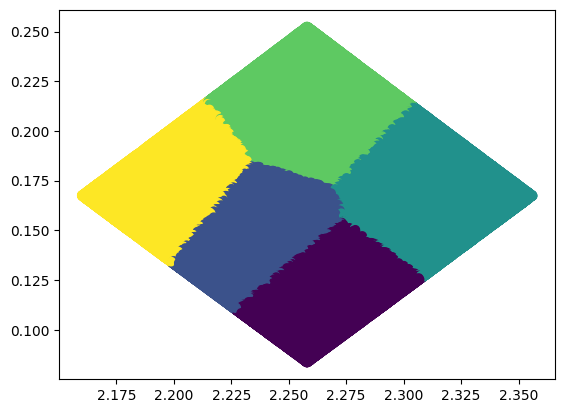

In [11]:
pl.scatter(galaxy.ra, galaxy.dec, c = galaxy.patch)

In [17]:
file_name="/pscratch/sd/q/qhang/desi-lya/example-unknown-yaw.fits"
fin = fits.open(file_name)
#fin[1].header

# add this to the catalogue & save
data_holder = {}
for key in ['RA','DEC','Z']:
    data_holder[key] = fin[1].data[key]

data_holder['PATCH_ID'] = galaxy.patch

fname = "/pscratch/sd/q/qhang/desi-lya/example-unknown-w-patch-yaw.fits"
save_catalog_to_fits(fname, data_holder)

In [9]:
fname = "/pscratch/sd/q/qhang/desi-lya/example-unknown-w-patch-yaw.fits"
fin=fits.open(fname)
np.unique(fin[1].data['PATCH_ID'])

array([0, 1, 2, 3, 4], dtype='>i8')

### run both yaw and treecorr with the same jk regions and compare the counts:

also test with or without randoms

In [30]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
get_logger(level="debug", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

YAW | yet_another_wizz v2.5.9.dev352+g0f2205e
INF | running in multiprocessing environment with 64 workers


In [31]:
# CONFIGURATION
patch_num = 5 # code will generate this number of patch centers from the reference randoms
config = Configuration.create(
    rmin=1,  # scalar or list of lower scale cuts
    rmax=20, # scalar or list of upper scale cuts
    unit="arcmin",
    #zmin=1.85,
    #zmax=3.00,
    #num_bins=20,
    edges=edges,
)

In [32]:
# LOADING CATALOGS
CACHE_DIR = "./cache_path/"
delete_and_recreate_cache_directory(CACHE_DIR)

In [33]:
cat_unknown = Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path="/pscratch/sd/q/qhang/desi-lya/example-unknown-w-patch-yaw.fits",
    ra_name="RA",
    dec_name="DEC",
    #weight_name="weight_column",  # optional
    #patch_num=patch_num,
    progress=PROGRESS,
    patch_name="PATCH_ID",
)
patch_centers = cat_unknown.get_centers()  # use these for all following catalogs

INF | loading 1.08M records in 1 chunks from FITS file: /pscratch/sd/q/qhang/desi-lya/example-unknown-w-patch-yaw.fits
DBG | selecting input columns: RA, DEC, PATCH_ID
DBG | dividing patches based on 'PATCH_ID'
DBG | running preprocessing on 64 workers


INF | using cache directory: ./cache_path/unknown


    |-> processed 1/1 (100%) t=0m00.31s


INF | computing patch metadata


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m01.00s


In [34]:
cat_reference = Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path="/pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits",
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    kappa_name="DELTAF",
    patch_centers=patch_centers,
    progress=PROGRESS,
)

cat_ref_rand = None 
#cat_unk_rand = None  # assuming you don't have this

INF | loading 44.2K records in 1 chunks from FITS file: /pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits
DBG | selecting input columns: RA, DEC, Z, DELTAF
DBG | applying 5 patches
DBG | running preprocessing on 64 workers


INF | using cache directory: ./cache_path/reference


    |-> processed 1/1 (100%) t=0m00.08s


INF | computing patch metadata


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.99s


In [35]:
# also load a random:
cat_unk_rand = Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path="/pscratch/sd/q/qhang/desi-lya/example-random-larger-yaw.fits",
    ra_name="RA",
    dec_name="DEC",
    #weight_name="weight_column",  # optional
    patch_centers=patch_centers,
    progress=PROGRESS,
)

INF | loading 5.02M records in 1 chunks from FITS file: /pscratch/sd/q/qhang/desi-lya/example-random-larger-yaw.fits
DBG | selecting input columns: RA, DEC
DBG | applying 5 patches
DBG | running preprocessing on 64 workers


INF | using cache directory: ./cache_path/unk_rand


    |-> processed 1/1 (100%) t=0m00.40s


INF | computing patch metadata


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m01.10s


Test the auto-correlation code:

In [31]:
# CORRELATION MEASUREMENTS
w_ss= autocorrelate_scalar(
    config,
    cat_reference,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_ss.to_file("...") -> store correlation pa7ir counts as HDF5 file

INF | building trees for 1 catalogs
DBG | building patch-wise trees (using 20 bins)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.62s


INF | computing auto-correlation with DD
DBG | computing patch linkage with max. separation of 5.82e-03 rad
DBG | created patch linkage with 21 patch pairs
DBG | using 1 scales without weighting


DBG | running parallel jobs on 64 workers


    |-> processed 13/13 (100%) t=0m00.64s


DBG | running parallel jobs on 64 workers


    |-> processed 13/13 (100%) t=0m00.65s


In [14]:
w_ss[0]

ScalarCorrFunc(counts=dd, auto=True, binning=20 bins @ (1.854...3.000], num_patches=5)

In [35]:
fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd.npy"
np.save(fname, w_ss[0].dd.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_weights.npy"
np.save(fname, w_ss[0].dd_weights.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_counts.npy"
np.save(fname, w_ss[0].dd.counts.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_weights_counts.npy"
np.save(fname, w_ss[0].dd_weights.counts.get_array())

now also test the cross-correlation code:

In [36]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=None,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_sp.to_file("...") -> store correlation pair counts as HDF5 file

INF | building trees for 2 catalogs
DBG | building patch-wise trees (using 20 bins)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.97s


DBG | building patch-wise trees (unbinned)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m01.08s


INF | computing cross-correlation with DD
DBG | computing patch linkage with max. separation of 5.82e-03 rad
DBG | created patch linkage with 23 patch pairs
DBG | using 1 scales without weighting


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m02.69s


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m02.83s


In [24]:
w_sp[0]

ScalarCorrFunc(counts=dd|dr, auto=False, binning=20 bins @ (1.854...3.000], num_patches=5)

In [37]:
fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd.npy"
np.save(fname, w_sp[0].dd.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_weights.npy"
np.save(fname, w_sp[0].dd_weights.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_counts.npy"
np.save(fname, w_sp[0].dd.counts.get_array())

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_weights_counts.npy"
np.save(fname, w_sp[0].dd_weights.counts.get_array())

In [37]:
w_sp_wr = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_sp.to_file("...") -> store correlation pair counts as HDF5 file

INF | building trees for 3 catalogs
DBG | building patch-wise trees (using 20 bins)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.91s


DBG | building patch-wise trees (unbinned)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.89s


DBG | building patch-wise trees (unbinned)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m01.79s


INF | computing cross-correlation with DD, DR
DBG | computing patch linkage with max. separation of 5.82e-03 rad
DBG | created patch linkage with 23 patch pairs
DBG | using 1 scales without weighting


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m02.58s


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m02.43s


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m09.29s


DBG | running parallel jobs on 64 workers


    |-> processed 23/23 (100%) t=0m08.61s


In [13]:
from yaw.correlation.measurements import compute_scalar_normalisation

kwargs = dict(progress=PROGRESS, max_workers=config.max_workers)
edges = config.binning.edges
closed = config.binning.closed
cat_reference.build_trees(edges, closed=closed, **kwargs)

norm = compute_scalar_normalisation(cat_reference, config.binning.binning)

DBG | building patch-wise trees (using 20 bins)


DBG | running parallel jobs on 64 workers


    |-> processed 5/5 (100%) t=0m00.60s


In [14]:
np.diag(norm.nn_counts.counts[2,:,:])

array([ 791.,  823., 1097., 1043.,  866.])

In [15]:
norm.nn_counts.sample_patch_sum().data

array([   0., 4227., 4620., 4639., 4406., 4122., 3714., 3381., 3023.,
       2659., 2239., 1849., 1511., 1182.,  924.,  683.,  506.,  316.,
        155.,   10.])

In [16]:
catalog = cat_reference
binning = config.binning.binning

In [17]:
from yaw.catalog.trees import BinnedTrees
from yaw.correlation.paircounts import (
    NormalisedCounts,
    NormalisedScalarCounts,
    PatchedCounts,
    PatchedSumWeights,
)

In [18]:
sum_kappa = np.empty((len(binning), catalog.num_patches, catalog.num_patches))
sum_weights = np.empty_like(sum_kappa)
for pid, patch in catalog.items():
    for bin_idx, tree in enumerate(BinnedTrees(patch)):
        sum_kappa[bin_idx, pid, pid] = tree.sum_kappa
        sum_weights[bin_idx, pid, pid] = tree.sum_weights

kk_counts = PatchedCounts(binning, sum_kappa, auto=False)
nn_counts = PatchedCounts(binning, sum_weights, auto=False)
#return NormalisedScalarCounts(kk_counts, nn_counts)

In [19]:
norm2 = NormalisedScalarCounts(kk_counts, nn_counts)

In [20]:
x1 = kk_counts.sample_patch_sum().samples

In [21]:
x11 = norm.kk_counts.sample_patch_sum().samples

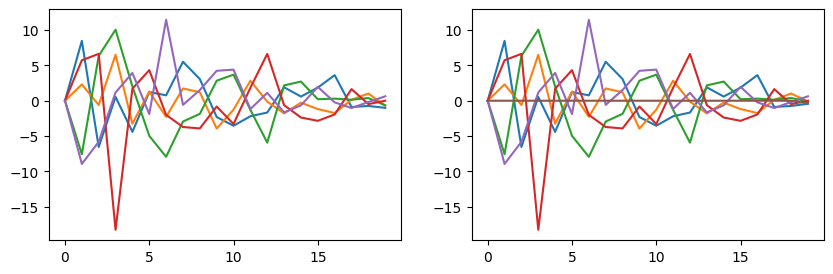

In [22]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    pl.plot(x1[ii,:])
    
    pl.sca(axarr[1])
    pl.plot(x11[ii,:])
pl.plot(np.mean(x1,axis=0)) # this is by design

In [23]:
x2 = nn_counts.sample_patch_sum().samples
x22 = norm.nn_counts.sample_patch_sum().samples

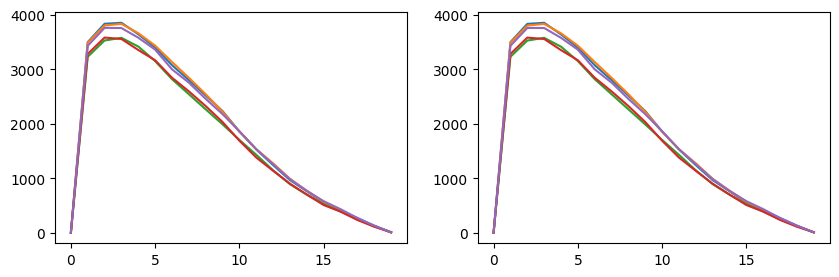

In [24]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    pl.plot(x2[ii,:])
    
    pl.sca(axarr[1])
    pl.plot(x22[ii,:])
#pl.plot(np.mean(x1,axis=0)) # this is by design

In [26]:
norm2.sample_patch_sum().data

array([ 9.99232142e-01,  4.20240558e-19, -3.84346720e-19, -2.87250969e-19,
        1.00716755e-18, -2.15474617e-19, -4.78314297e-19, -6.56742398e-20,
       -2.35045563e-18,  6.67720230e-19, -1.58648441e-18,  9.60216510e-19,
        1.17430671e-18,  1.31498497e-18,  1.92246411e-18,  1.62550955e-18,
       -1.37132291e-18, -1.40534560e-18, -3.58136460e-18, -5.80640793e-02])

In [30]:
norm.sample_patch_sum().data

array([            nan,  4.20240558e-19, -3.84492822e-19, -2.87188538e-19,
        1.00791922e-18, -2.15472688e-19, -4.78286710e-19, -6.56742398e-20,
       -2.35045563e-18,  6.68054471e-19, -1.58674126e-18,  9.60712190e-19,
        1.17561670e-18,  1.31498497e-18,  1.92246411e-18,  1.62550955e-18,
       -1.37132291e-18, -1.40534560e-18, -3.58136460e-18,  0.00000000e+00])

In [28]:
x3 = norm.sample_patch_sum().samples
x5 = norm2.sample_patch_sum().samples

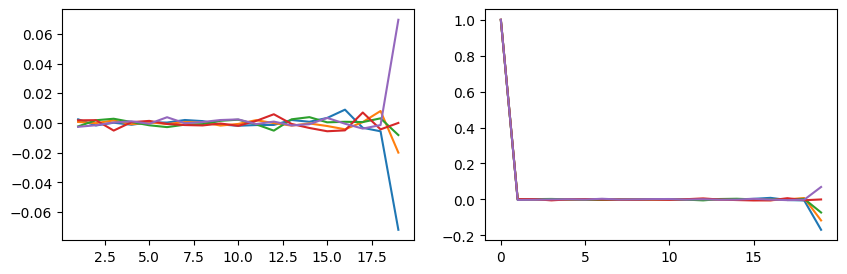

In [29]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    pl.plot(x3[ii,:])
    pl.sca(axarr[1])
    pl.plot(x5[ii,:])

Processing the results

In [30]:
# COMPUTE REDSHIFTS
ncc = RedshiftData.from_corrfuncs(cross_corr=w_sp[0], ref_corr=w_ss[0])  # unk_corr=w_pp
ncc.to_files("nz_estimate")  # store as ASCII files with extensions .dat, .smp and .cov
# useful attributes:
#   ncc.data -> estiamte
#   ncc.error -> Gaussian error estimate
#   ncc.covariance -> jackknife covariance
#   ncc.plot()

DBG | sampling correlation function with estimator 'SC'
DBG | sampling correlation function with estimator 'SC'
DBG | computing clustering redshifts from correlation function samples
DBG | mitigating reference sample bias
INF | writing RedshiftData to: nz_estimate.{dat,smp,cov}


In [31]:
ncc.data, ncc.error

(array([        nan, -0.21599349, -0.25307954, -0.33342385, -0.54573439,
        -0.42111037, -0.9632445 , -0.32044747, -0.7400895 , -0.60711905,
        -0.66827571, -0.54503513, -0.37729379, -0.08728049, -0.55116898,
        -0.17204238, -0.49273419,  0.08117866, -0.0718809 ,         nan]),
 array([       nan, 1.82960495, 3.02329115, 5.28922702, 1.33017454,
        2.39520057, 4.15551657, 2.32889361, 2.32734165, 2.80676909,
        1.9451088 , 1.62881971, 4.34286005, 2.36178827, 2.47272968,
        2.73741438, 4.74857416, 7.3233229 , 2.59930322,        nan]))

<Axes: >

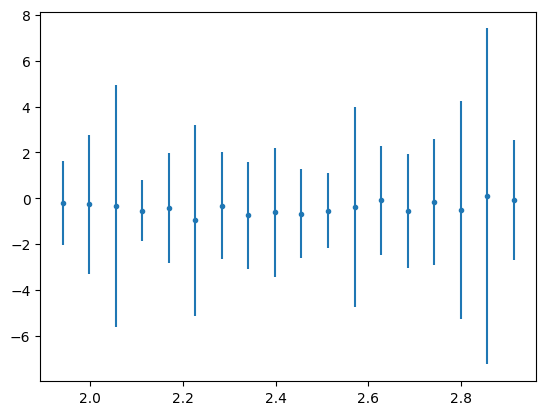

In [32]:
ncc.plot()

Check results separately: auto- and cross-correlations

DBG | sampling correlation function with estimator 'SC'


(0.0, 0.003)

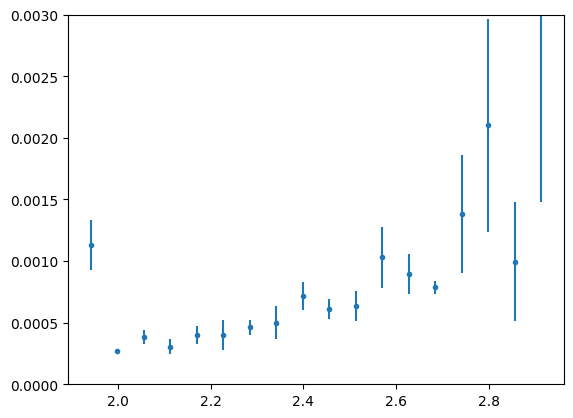

In [73]:
w_ss_samp = w_ss[0].sample()  # creates a CorrFunc object
w_ss_samp.plot()  # automatic plot
#pl.errorbar(zcen, res_holder[:,0],yerr=res_holder[:,1])
pl.ylim([0,0.003])

DBG | sampling correlation function with estimator 'SC'


(0.0, 0.003)

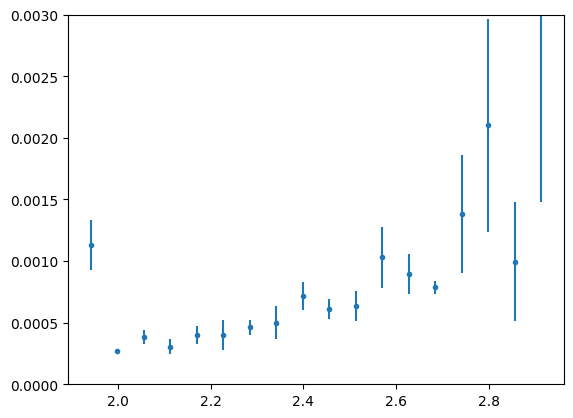

In [33]:
w_ss_samp = w_ss[0].sample()  # creates a CorrFunc object
w_ss_samp.plot()  # automatic plot
#pl.errorbar(zcen, res_holder[:,0],yerr=res_holder[:,1])
pl.ylim([0,0.003])

DBG | sampling correlation function with estimator 'SC'


(-0.01, 0.01)

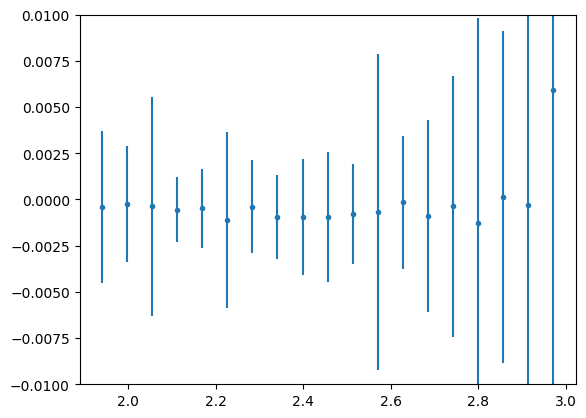

In [74]:
w_sp_samp = w_sp[0].sample()  # creates a CorrFunc object
w_sp_samp.plot()  # automatic plot
pl.ylim([-0.01,0.01])

DBG | sampling correlation function with estimator 'SC'
DBG | sampling correlation function with estimator 'SC'


Text(0.5, 1.0, 'Test sample on 1 HEALPIX with nside=8')

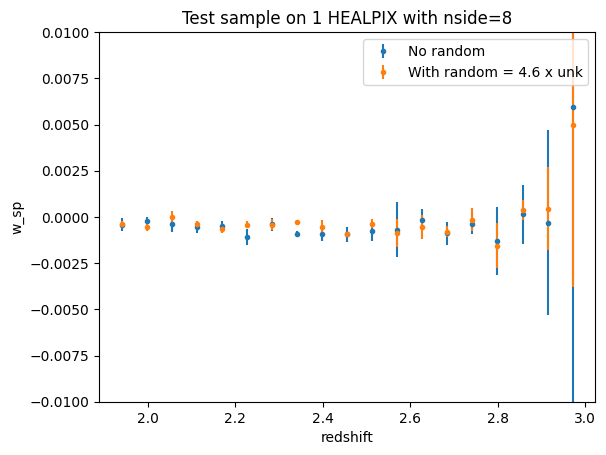

In [42]:
w_sp_samp = w_sp[0].sample()  # creates a CorrFunc object
w_sp_samp.plot(label="No random")  # automatic plot
pl.ylim([-0.01,0.01])

w_sp_samp_wr = w_sp_wr[0].sample()  # creates a CorrFunc object
w_sp_samp_wr.plot(label="With random = 4.6 x unk")  # automatic plot
pl.ylim([-0.01,0.01])
pl.legend()

pl.xlabel("redshift")
pl.ylabel("w_sp")
pl.title("Test sample on 1 HEALPIX with nside=8")

In [83]:
zbin=8

mean2 = w_sp_wr[0].dr.kk_counts.counts[zbin,:,:]/w_sp_wr[0].dr.nn_counts.counts[zbin,:,:]
#pl.imshow(mean2,vmax=0.01,vmin=-0.01)
#pl.colorbar(label="RK")

k2 = w_sp_wr[0].dr.kk_counts.counts[zbin,:,:]
n2 = w_sp_wr[0].dr.nn_counts.counts[zbin,:,:]

# per patch check:
print(np.diag(mean2))

# per jn sample check:
jk_samp2 = np.zeros(5)
for ii in range(5):
    mask = np.ones(5)
    mask[ii]=0
    mask=mask.astype(bool)
    sel = k2[mask,:]
    sel = sel[:,mask]
    sel = sum(sel.flatten())
    
    sell = n2[mask,:]
    sell = sell[:,mask]
    sell = sum(sell.flatten())
    
    jk_samp2[ii] = sel/sell
print(jk_samp2)

[-0.00807867 -0.00271697  0.00162189  0.00476529 -0.00280001]
[ 6.13577353e-04 -1.99069723e-04 -1.77750234e-03 -2.43282187e-03
  1.96421840e-05]


In [84]:
mean1 = w_sp[0].dr.kk_counts.counts[zbin,:,:]/w_sp[0].dr.nn_counts.counts[zbin,:,:]
#pl.imshow(mean1,vmax=0.01,vmin=-0.01)
#pl.colorbar(label="<k>")
# per patch check:
print(np.diag(mean1))

k1=w_sp[0].dr.kk_counts.counts[zbin,:,:]
n1=w_sp[0].dr.nn_counts.counts[zbin,:,:]

# per jn sample check:
jk_samp1 = np.zeros(5)
for ii in range(5):
    mask = np.ones(5)
    mask[ii]=0
    mask=mask.astype(bool)
    sel = k1[mask,:]
    sel = sel[:,mask]
    sel = sum(sel.flatten())
    
    sell = n1[mask,:]
    sell = sell[:,mask]
    sell = sum(sell.flatten())
    
    jk_samp1[ii] = sel/sell
print(jk_samp1)

[-0.00605024 -0.00248605  0.00244742  0.00560351 -0.00266042]
[ 0.00122208  0.00047391 -0.00082338 -0.00169167  0.00061686]


Text(0.5, 1.0, 'zbin = 8')

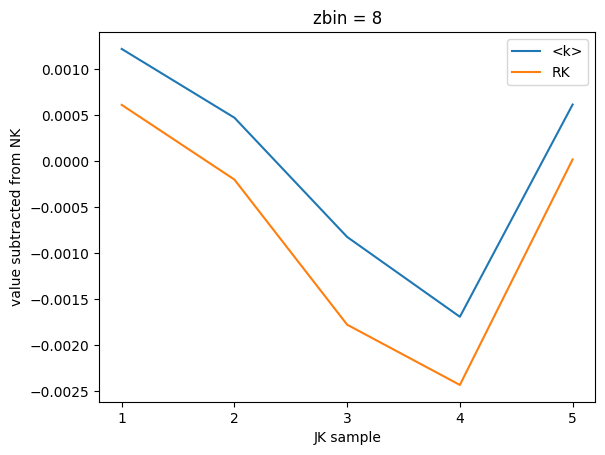

In [85]:
pl.plot(np.arange(5)+1,jk_samp1,label="<k>")
pl.plot(np.arange(5)+1,jk_samp2,label="RK")
pl.xticks(np.arange(5)+1)
pl.xlabel("JK sample")
pl.ylabel("value subtracted from NK")
pl.legend()
pl.title(f"zbin = {zbin}")

Text(0, 0.5, 'Value subtracted from NK, whole field')

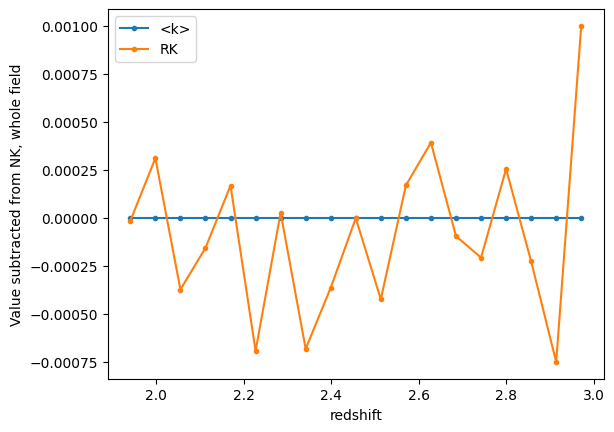

In [113]:
use1= w_sp[0].dr.kk_counts.sample_patch_sum().data / w_sp[0].dr.nn_counts.sample_patch_sum().data

use2 = w_sp_wr[0].dr.kk_counts.sample_patch_sum().data / w_sp_wr[0].dr.nn_counts.sample_patch_sum().data

pl.plot(zsamp, use1,'.-',label="<k>")
pl.plot(zsamp, use2,'.-',label="RK")
pl.legend()
pl.xlabel("redshift")
pl.ylabel("Value subtracted from NK, whole field")

In [35]:
w_sp_samp.data

array([        nan, -0.00041591, -0.000237  , -0.00037416, -0.00054686,
       -0.0004829 , -0.00110201, -0.00039416, -0.00094907, -0.00093294,
       -0.00094651, -0.00078499, -0.00069347, -0.00014925, -0.00088632,
       -0.00036635, -0.00129362,  0.00014659, -0.0003066 ,  0.00594956])

zbin 7 mean deltaF 7.880908781722496e-19
zbin 8 mean deltaF -1.6159382429211673e-18


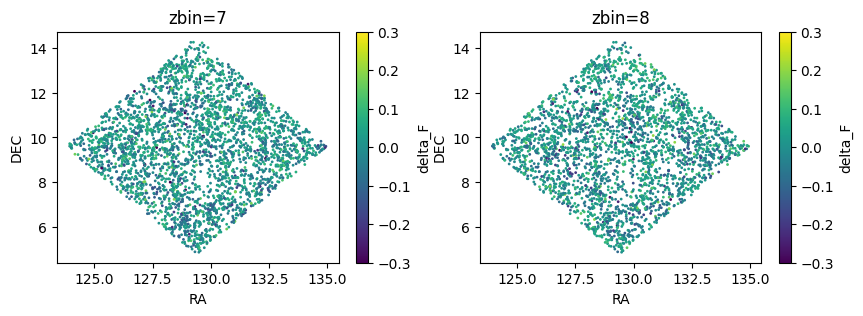

In [99]:
# check bin 7 and 8 distribution of the deltaF sample:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits")
z=fin[1].data['Z']
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii, zbin in zip(np.arange(2),[7,8]):
    pl.sca(axarr[ii])
    sel = (z>edges[zbin]) & (z<edges[zbin+1])
    rasel = fin[1].data['RA'][sel]
    decsel = fin[1].data['DEC'][sel]
    delf = fin[1].data['DELTAF'][sel]
    pl.scatter(rasel,decsel,s=1,c=delf,vmax=0.3,vmin=-0.3)
    pl.title(f"zbin={zbin}")
    pl.xlabel("RA")
    pl.ylabel("DEC")
    pl.colorbar(label="delta_F")
    print(f"zbin {zbin} mean deltaF", np.mean(delf))

# Validation with treecorr

In [39]:
galaxy = treecorr.Catalog(file_name="/pscratch/sd/q/qhang/desi-lya/example-unknown-w-patch-yaw.fits",
                          ra_col='RA', dec_col='DEC',
                          ra_units='deg', dec_units='deg', 
                          patch_col='PATCH_ID',
                          )

In [76]:
# for comparison with tree corr, let's turn off the rweight
# here we can compute the tree corr auto-correlation within this range:
cat = fits.open("/pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits")
z = cat[1].data['Z']

# need to separate into redshift bins and carry out the correlation for each one:
res_holder_kk = np.zeros((len(edges)-1,5,5))
res_holder_kk_counts = np.zeros((len(edges)-1,5,5))
res_holder_nk = np.zeros((len(edges)-1,5,5))
res_holder_nk_counts = np.zeros((len(edges)-1,5,5))
xmeasurements_error = np.zeros((len(edges)-1,2))

for ii in range(len(edges)-1):
    
    sel = (z>=edges[ii])&(z<edges[ii+1])
    
    if len(z[sel])>0:
        
        print(f"Running on bin {ii}...")
        
        #angs = angles_arcmin[ii]
        kk = treecorr.KKCorrelation(min_sep=1, max_sep=20, nbins=1, sep_units='arcmin',
                                   bin_slop=0, var_method='jackknife')
        
        deltaF = treecorr.Catalog(
                          ra=cat[1].data['RA'][sel], dec=cat[1].data['DEC'][sel],
                          ra_units='deg', dec_units='deg', 
                          k=cat[1].data['DELTAF'][sel], 
                          patch_centers=galaxy.patch_centers,
                         )
        kk.process(deltaF)
        
        for (pid1, pid2), corr_result in kk.results.items():
            res_holder_kk[ii, pid1, pid2] = corr_result.xi
            res_holder_kk_counts[ii, pid1, pid2] = corr_result.npairs
        
        
        nk = treecorr.NKCorrelation(min_sep=1, max_sep=20, nbins=1, sep_units='arcmin',
                                   bin_slop=0, var_method='jackknife')
        
        nk.process(galaxy,deltaF)
        
        for (pid1, pid2), corr_result in nk.results.items():
            res_holder_nk[ii, pid1, pid2] = corr_result.xi
            res_holder_nk_counts[ii, pid1, pid2] = corr_result.npairs
            
        xmeasurements_error[ii,0]=nk.raw_xi
        xmeasurements_error[ii,1]=np.sqrt(nk.raw_varxi)

Running on bin 1...
Running on bin 2...
Running on bin 3...
Running on bin 4...
Running on bin 5...
Running on bin 6...
Running on bin 7...
Running on bin 8...
Running on bin 9...
Running on bin 10...
Running on bin 11...
Running on bin 12...
Running on bin 13...
Running on bin 14...
Running on bin 15...
Running on bin 16...
Running on bin 17...
Running on bin 18...
Running on bin 19...
The following patch numbers have no objects: {3}
This may be a problem depending on your use case.


(-0.01, 0.01)

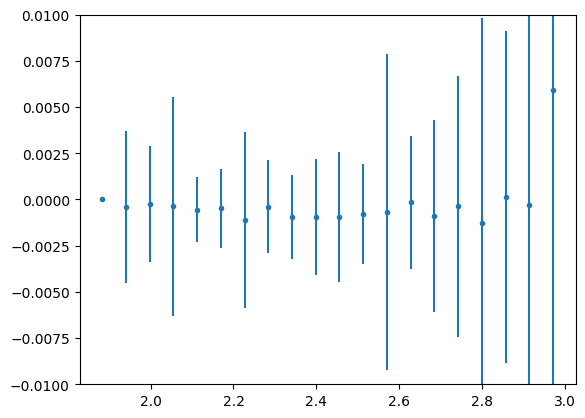

In [81]:
pl.errorbar(zsamp,xmeasurements_error[:,0],yerr=xmeasurements_error[:,1],fmt='.')
pl.ylim([-0.01,0.01])

In [60]:
# save the treecorr results:
fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_kk.npy"
np.save(fname, res_holder_kk)

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_kk_counts.npy"
np.save(fname, res_holder_kk_counts)

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_nk.npy"
np.save(fname, res_holder_nk)

fname = "/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_nk_counts.npy"
np.save(fname, res_holder_nk_counts)

<ErrorbarContainer object of 3 artists>

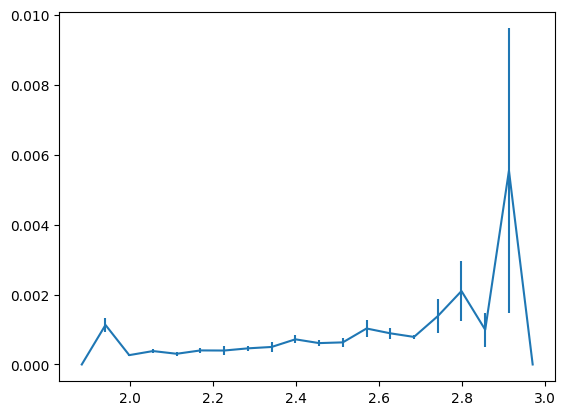

In [34]:
pl.errorbar(zsamp, res_holder[:,0], yerr=np.sqrt(res_holder[:,1]))

In [54]:
meank = np.zeros(len(zbin_edges)-1)
for ii in range(len(zbin_edges)-1):
    
    sel = (z>=zbin_edges[ii])&(z<zbin_edges[ii+1])
    
    if len(z[sel])>0:
        
        k=cat[1].data['DELTAF'][sel]
        meank[ii] = np.mean(k)

<ErrorbarContainer object of 3 artists>

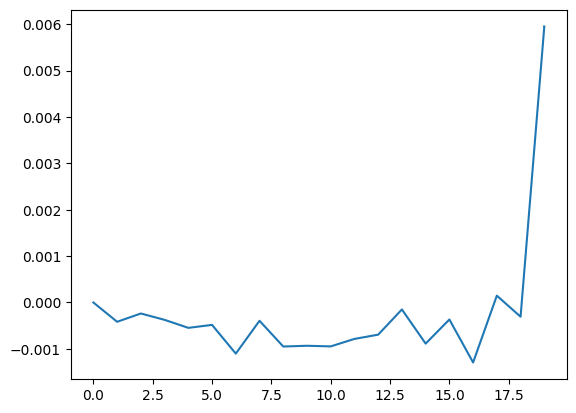

In [58]:
#pl.errorbar(np.arange(len(res_holder_nk[:,0])), res_holder_nk[:,0], yerr=res_holder_nk[:,1])
pl.errorbar(np.arange(len(res_holder_nk[:,0])), res_holder_nk[:,0]-meank, yerr=res_holder_nk[:,1])

#### compare the two methods:

In [61]:
# load all results:

kk_treecorr = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_kk.npy")
kk_counts_treecorr = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_kk_counts.npy")
nk_treecorr = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_nk.npy")
nk_counts_treecorr = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/treecorr_nk_counts.npy")


wss_dd_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd.npy")
wss_dd_weights_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_weights.npy")
wss_dd_counts_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_counts.npy")
wss_dd_weights_counts_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_ss_dd_weights_counts.npy")

wsp_dd_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd.npy")
wsp_dd_weights_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_weights.npy")
wsp_dd_counts_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_counts.npy")
wsp_dd_weights_counts_yaw = np.load("/pscratch/sd/q/qhang/desi-lya/test_algo/w_sp_dd_weights_counts.npy")

In [ ]:
# can compute scatter between these pairs

In [66]:
nk_counts_treecorr[:,1,0]

array([     0., 117433., 125213., 118025., 114242., 112279., 101522.,
        98522.,  88805.,  67615.,  64090.,  51141.,  41924.,  33155.,
        30403.,  25552.,  22543.,   4384.,   3775.,   1132.])

In [64]:
wsp_dd_weights_counts_yaw[:,0,1]

array([     0., 117429., 125209., 118021., 114242., 112279., 101522.,
        98522.,  88805.,  67615.,  64090.,  51141.,  41924.,  33155.,
        30403.,  25552.,  22543.,   4384.,   3775.,   1132.])

In [67]:
wsp_dd_weights_yaw[:,0,1]

array([           nan, 2.56518486e-05, 2.50247141e-05, 2.34914850e-05,
       2.39418033e-05, 2.51516281e-05, 2.52402597e-05, 2.69068961e-05,
       2.71253172e-05, 2.34801176e-05, 2.64308866e-05, 2.55392335e-05,
       2.56196859e-05, 2.59004380e-05, 3.03822562e-05, 3.45445666e-05,
       4.11373913e-05, 1.28102916e-05, 2.24885167e-05, 1.04525434e-04])

In [69]:
wsp_dd_counts_yaw[:,0,1]

array([    0.        ,   141.04741939,   388.75930502,   475.44194435,
         276.75920163,  1048.07308088,  -685.4247826 ,    52.05610038,
         602.92819747,  1648.89749843,   535.77102331, -1782.21071759,
        1574.5021956 ,    96.4245155 ,   473.58909969,  -610.94471018,
       -1066.35189097,  -110.47222587,  -324.8080378 ,   215.50961694])

In [71]:
wsp_dd_yaw[:,0,1]

array([            nan,  3.08111885e-08,  7.76988114e-08,  9.46343218e-08,
        5.80006859e-08,  2.34778937e-07, -1.70409365e-07,  1.42168052e-08,
        1.84163263e-07,  5.72599382e-07,  2.20953396e-07, -8.90015753e-07,
        9.62175645e-07,  7.53261104e-08,  4.73265973e-07, -8.25955708e-07,
       -1.94592268e-06, -3.22805983e-07, -1.93495390e-06,  1.98995020e-05])

In [70]:
nk_treecorr[:,1,0]

array([    0.        ,   140.83609335,   388.48572129,   475.50712679,
         276.75919692,  1048.07309681,  -685.42479702,    52.05610519,
         602.92823141,  1648.89746714,   535.77105525, -1782.2107118 ,
        1574.50218651,    96.42448981,   473.58909433,  -610.94473198,
       -1066.3518985 ,  -110.47222758,  -324.80805392,   215.50961131])

In [ ]:
# seems like there is reasonable agreement between the two

# save a small testing catalogue for yaw testing:

In [23]:
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
mask_dg = hp.ud_grade(mask, 8)
usepix = np.arange(int(12*8**2))[mask_dg==1]
print(usepix[0])

315


In [17]:
galaxy = fits.open("/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap.fits")

redshift = galaxy[1].data['Z_COSMO']+galaxy[1].data['DZ_RSD']
sel = redshift > 1.8

# also select objects inside the pixel

ra = galaxy[1].data['RA']
dec = galaxy[1].data['DEC']

pix = hp.ang2pix(8,
             np.radians(90 - dec),
             np.radians(ra))

sel = sel * pix == usepix[0]

print(len(redshift[sel]))

1082990


In [19]:
# okay save this catalogue:
fname = "/pscratch/sd/q/qhang/desi-lya/example-unknown-yaw.fits"
data_holder = {
    "RA": ra[sel],
    "DEC": dec[sel],
    "Z": redshift[sel],
}
save_catalog_to_fits(fname, data_holder)

In [7]:
# lya:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/delta-laura-comb.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =             16618646 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z_BIN   '        

In [8]:
zbin_convert = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
zz = zbin_convert[:-1,1]
zbin_convert[:,0]
#zbin.min(), zbin.max()

array([1.85439301, 1.91167006, 1.96894712, 2.02622418, 2.08350124,
       2.1407783 , 2.19805536, 2.25533242, 2.31260948, 2.36988654,
       2.4271636 , 2.48444066, 2.54171772, 2.59899478, 2.65627184,
       2.7135489 , 2.77082596, 2.82810302, 2.88538008, 2.94265714,
       2.9999342 ])

In [13]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
zbin = fin[1].data['Z_BIN'] # need to map this to redshift
print(np.unique(zbin))

ra = ra*180/np.pi
dec = dec*180/np.pi

deltaF_holder = {}
nside=8

pix = hp.ang2pix(nside,
             np.radians(90 - dec),
             np.radians(ra))
sel = pix ==  usepix[0]
z = zz[zbin-1]

ra = ra[sel]
dec = dec[sel]
z = z[sel]
deltaF = fin[1].data['DELTA_F'][sel]

for ii in range(2,21):
    ind = zbin[sel] == ii
    print(np.mean(deltaF[ind]))
    deltaF[ind] -= np.mean(deltaF[ind])

print(len(ra))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0.005976301182976724
0.0003655306074613332
-0.005912162644248406
0.006308742009326399
-0.00028331184828985016
-0.005296687916810601
0.003923451764582173
-0.0022070993919143292
0.001296016253858603
-0.0011834572804697884
-0.0054475889841689145
0.0013393967878196397
-0.010831755943527014
0.002299737888449594
0.00851760524811163
0.001380383675730153
0.006034599411143885
-0.0025973838245289794
0.133306714146308
44166


In [15]:
# okay save this catalogue:
fname = "/pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits"
data_holder = {
    "RA": ra,
    "DEC": dec,
    "Z": z,
    "DELTAF":deltaF,
}
save_catalog_to_fits(fname, data_holder)

In [16]:
cat = fits.open("/pscratch/sd/q/qhang/desi-lya/example-unknown-yaw.fits")
ra = cat[1].data['RA']
dec = cat[1].data['DEC']

In [17]:
cat2 = fits.open("/pscratch/sd/q/qhang/desi-lya/example-reference-yaw.fits")
ra2 = cat2[1].data['RA']
dec2 = cat2[1].data['DEC']

# save a big testing catalogue for yaw testing:

In [8]:
galaxy = fits.open("/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap.fits")

redshift = galaxy[1].data['Z_COSMO']+galaxy[1].data['DZ_RSD']
sel = redshift > 1.8
print(len(redshift[sel]))

# okay save this catalogue:
fname = "/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap-zmin-1.8.fits"
data_holder = {
    "RA": galaxy[1].data['RA'][sel],
    "DEC": galaxy[1].data['DEC'][sel],
    "Z": redshift[sel],
}
save_catalog_to_fits(fname, data_holder)

110938487


In [40]:
# lya:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/delta-laura-comb.fits")

ra = fin[1].data['RA']
dec = fin[1].data['DEC']
zbin = fin[1].data['Z_BIN'] # need to map this to redshift

ra = ra*180/np.pi
dec = dec*180/np.pi

nside=128

mask_pix = np.arange(int(12*nside**2))[mask.astype(bool)]

pix = hp.ang2pix(nside,
             np.radians(90 - dec),
             np.radians(ra))

sel = np.isin(pix, mask_pix)
z = zz[zbin-1]

ra = ra[sel]
dec = dec[sel]
z = z[sel]
deltaF = fin[1].data['DELTA_F'][sel]

for ii in range(2,21):
    ind = zbin[sel] == ii
    print(np.mean(deltaF[ind]))
    deltaF[ind] -= np.mean(deltaF[ind])

print(len(ra))

# okay save this catalogue:
fname = "/pscratch/sd/q/qhang/desi-lya/delta-laura-comb-overlap.fits"
data_holder = {
    "RA": ra,
    "DEC": dec,
    "Z": z,
    "DELTAF":deltaF,
}
save_catalog_to_fits(fname, data_holder)

0.00024251608089297057
0.000351990980936301
-0.0004838336211825767
0.00022726559989930445
0.0005836394725878544
0.00010043167298379607
0.0004981499717640212
-0.00020003908334772857
0.00037182784161817487
-0.0007668585224279721
-0.00037688136961965614
0.0006869939060223904
-0.0006843041632093518
-0.00034157588911909215
0.001138823841106211
0.0009528102616785258
-0.0012614994797262385
-0.0021687044897000887
0.013709918079655405
4561814


# Make random catalogue for photometric survey

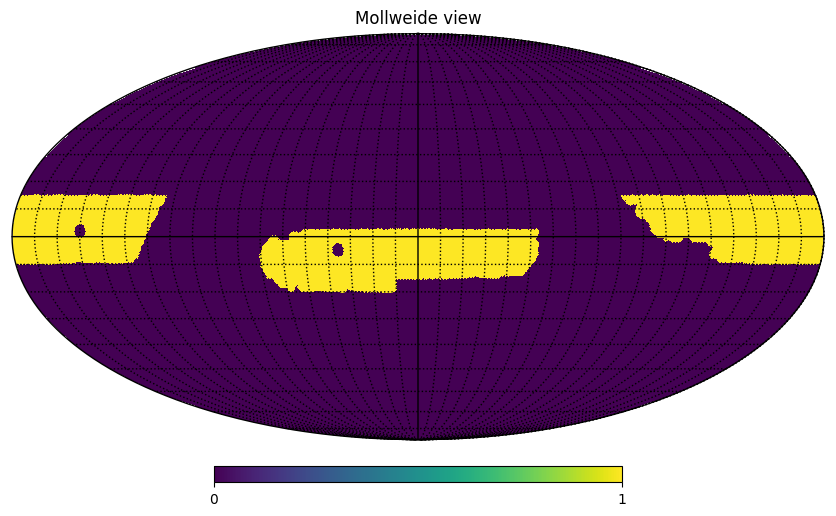

In [10]:
hp.mollview(mask)
hp.graticule(dpar=10, dmer=10)

In [19]:
# make random catalogue
ra_min = 0/180.*np.pi
ra_max = 360/180.*np.pi
dec_min = -25/180.*np.pi
dec_max = 20/180.*np.pi
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

nside=128
mask_pix = np.arange(len(mask))[mask.astype(bool)]
for ii in range(5):
    tmp_ra = np.random.uniform(ra_min, ra_max, int(1e8))
    tmp_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), int(1e8))
    tmp_dec = np.arcsin(tmp_sindec)

    # select inside the pixel:
    pix_rand = hp.ang2pix(nside,
                     np.radians(90 - tmp_dec*180/np.pi),
                     np.radians(tmp_ra*180/np.pi))
    sel = np.isin(pix_rand, mask_pix)
    
    if ii==0:
        rand_ra = tmp_ra[sel]*180/np.pi
        rand_dec =tmp_dec[sel]*180/np.pi
        
    else:
        rand_ra = np.append(rand_ra, tmp_ra[sel]*180/np.pi)
        rand_dec = np.append(rand_dec, tmp_dec[sel]*180/np.pi)
print(len(rand_ra))

ra range = 0.000000 .. 6.283185
dec range = -0.436332 .. 0.349066
174112728


In [20]:
# save the catalogue:
data_holder = {
    'RA': rand_ra,
    'DEC': rand_dec,
}
fname = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-zmin-1.8.fits"
save_catalog_to_fits(fname, data_holder)

### make a small version for testing

In [39]:
fname = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-zmin-1.8.fits"
fin = fits.open(fname)

ra = fin[1].data['RA']
dec = fin[1].data['DEC']

pix = hp.ang2pix(8,
             np.radians(90 - dec),
             np.radians(ra))

sel = pix == usepix[0]

print(len(ra[sel]))

1702755


In [40]:
# save the catalogue:
data_holder = {
    'RA': ra[sel],
    'DEC': dec[sel],
}
fname = "/pscratch/sd/q/qhang/desi-lya/example-random-yaw.fits"
save_catalog_to_fits(fname, data_holder)

In [22]:
fin=fits.open("/pscratch/sd/q/qhang/desi-lya/example-random-yaw.fits")
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
print(ra.max(), ra.min(), dec.max(), dec.min())

134.99513845563487 123.75149190293068 14.474591180758193 4.783758371279323


In [24]:
print(len(ra))

1702755


In [28]:
# generate a bigger random sample:
# make random catalogue
ra_min = (ra.min() - 1)/180.*np.pi
ra_max = (ra.max() + 1)/180.*np.pi
dec_min = (dec.min() - 1)/180.*np.pi
dec_max = (dec.max() - 1)/180.*np.pi
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

nside=8
mask_pix = np.arange(len(mask))[mask.astype(bool)]

tmp_ra = np.random.uniform(ra_min, ra_max, int(8e6))
tmp_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), int(8e6))
tmp_dec = np.arcsin(tmp_sindec)

# select inside the pixel:
pix = hp.ang2pix(nside,
                 np.radians(90 - tmp_dec*180/np.pi),
                 np.radians(tmp_ra*180/np.pi))
sel = pix == usepix[0]

rand_ra = np.append(ra, tmp_ra[sel]*180/np.pi)
rand_dec = np.append(dec, tmp_dec[sel]*180/np.pi)

print(len(tmp_ra[sel]), len(rand_ra))

ra range = 2.142418 .. 2.373563
dec range = 0.066039 .. 0.235176
3321127 5023882


In [29]:
# save the catalogue:
data_holder = {
    'RA': rand_ra,
    'DEC': rand_dec,
}
fname = "/pscratch/sd/q/qhang/desi-lya/example-random-larger-yaw.fits"
save_catalog_to_fits(fname, data_holder)

In [39]:
5023882 / 1082990

4.638899712832067